# Extraction des données d'un poste de Météo France
Ce cahier permet de visualiser les postes de Météo-France, d'extraire les données et de les traiter.
Pour cartographier des postes de mesure, je me suis appuyé notamment sur des scripts écrits par Loïc Duffar (https://github.com/loicduffar/meteo.data-Tools/).
Pour l'analyse des valeurs extrêmes, je me sers du travail de George Bocharov (https://georgebv.github.io/pyextremes/), et en particulier son module pyextreme.

Météo-France a deux types de postes : les postes de mesures automatiques que j'appelle ici "climato" et les autres postes, qui sont essentiellement des postes de nivo-métérologie dans les stations de ski ou les balises Nivôse en altitude. Le problème est que si Météo-France fournit la liste des postes climatologiques sur son site internet, elle ne le fait pas pour les autres postes. Le seul moyen de le savoir est de télécharger tous les fichiers et examiner les numéros de poste. Un script "création-liste-poste.ipynb" fait ce travail fastidieux ; ce script génère une liste des postes non recensés par Météo-France et crée un fichier xlsx avec la localisation et d'autres informations sur ces postes. Il faut renseigner :
* l'adresse du répertoire où se situe le fichier, ici 
```
répertoire_postes = '/home/ancey/Météo-France/postes/'
```
* le nom du fichier, ici 
```
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'
```

##### Lecture du fichier JSON 

In [1]:
%matplotlib inline
import pandas as pd
import os
import datetime
import json
import requests
import sys
import plotly.express as px
import plotly.graph_objects as go
import openpyxl                           # exporte excel
import numpy as np
import gzip
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import colors as mcolors
from scipy import stats
from pyextremes import EVA                # valeurs extrêmes
colors = mcolors._colors_full_map
plt.rcParams['text.usetex'] = True

################################
## Auteur : Christoophe Ancey ##
## Date : Mai 2024            ##
################################

#-------------------------------------------
# Lecture du fichier de postes  
#-------------------------------------------
# adresse du répertoire de travail
répertoire_principal = '/home/ancey/Météo-France/meteo.data/base'
# teste si le répertoire existe
if not os.path.exists(répertoire_principal):
    # s'il n'existe pas le créer
    os.makedirs(répertoire_principal)
    print("J'ai créé le répertoire : ", répertoire_principal)
else:
    print("J'ai trouvé le répertoire : ", répertoire_principal)
 
os.chdir(répertoire_principal)
print("Je me place dans le répertoire : "+os.getcwd())

# Ma liste de postes sur le disque
répertoire_postes = '/home/ancey/Météo-France/postes/'
fichier_postes_alpes = 'liste_synthétique_Alpes_Nord.xlsx'
if os.path.exists(répertoire_postes):
    liste_fichier = [f for f in os.listdir(répertoire_postes) if os.path.isfile(os.path.join(répertoire_postes, f))]
    if fichier_postes_alpes  in liste_fichier: 
        liste_postes_alpes = pd.read_excel(os.path.join(répertoire_postes,fichier_postes_alpes))
        liste_postes_alpes['poste'] = liste_postes_alpes['poste'].astype(str)
        print("J'ai téléchargé le fichier ", fichier_postes_alpes)
        # ce booléen indique si le fichier "fichier_postes_alpes" a été chargé
        chargement_nivo = True
    else:
        print("Je n'ai pas trouvé de fichier des postes dans le répertoire principal.")
        print("Ce dernier peut être généré avec création_liste_postes.ipynb")
        chargement_nivo = False

# Météo France fournit un fichier JSON avec la liste de tous les postes
url_liste_postes= "https://www.data.gouv.fr/fr/datasets/r/1fe544d8-4615-4642-a307-5956a7d90922"
# Lecture en ligne du fichier JSON avec test de la connexion
requête = requests.get(url_liste_postes)
# teste si le fichier en ligne existe
if requête.status_code == 200:
    print("J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....")
    data_json= requête.json()
elif requête.status_code == 404:
    print("Erreur : fichier non trouvé !")
    sys.exit()
else:
    print("La requête a échoué. Le code d'erreur est ", requête.status_codes)
    sys.exit()
# il faut prendre le transposé (si cela plante, enlever ".T")
metadata_MF = pd.DataFrame(data_json['features']).T

# fonction pour télécharger les fichiers MF
def télécharger_fichier(url, nom_fichier, work_verbosity = True):
    fichier = os.path.join(répertoire_principal, nom_fichier) + '.gz'
    if os.path.isfile(fichier):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        requête_données = requests.get(url)
        if requête_données.status_code == 200:
            with open(fichier,mode='wb') as file:
             file.write(requête_données.content)
            if work_verbosity: print('Téléchargement : ', fichier)    
        else:
            print("Le lien ", url, "ne marche pas !")
            sys.exit()

# fonction pour décompresser les fichiers MF
def décompresser_archive(archive, work_verbosity = True):
    fichier             = os.path.join(répertoire_principal, archive) + '.gz'
    fichier_décompressé = os.path.join(répertoire_principal, archive) + '.csv'
    if os.path.isfile(fichier_décompressé):
        if work_verbosity: print("Rien à faire. Le fichier est déjà présent.")
    else:
        if os.path.exists(fichier):
            with gzip.open(fichier, mode='rb') as f_in:
                with open(fichier_décompressé, mode='wb') as f_out:
                    f_out.write(f_in.read())
            if work_verbosity: print('Archive décompressée : ', fichier)
        else:
            print("L'archive ", fichier, " n'est pas présente !")
            print("Téléchargez tout d'abord l'archive...")

# début des mesures au niveau départemental
an_début = {}
an_début['01'] = '1852'
an_début['04'] = '1872'
an_début['05'] = '1877'
an_début['06'] = '1877'
an_début['25'] = '1852'
an_début['26'] = '1877'
an_début['38'] = '1872'
an_début['73'] = '1871'
an_début['74'] = '1876'
liste_départements = {'01','04','05','06','25','26','38','73','74'}
url_M1_département = {}
url_M2_département = {}
url_M3_département = {}
url_N1_département = {}
url_N2_département = {}
url_N3_département = {}
# adresse url de base
base_url = 	"https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_"
for département in liste_départements:
      url_N1_département[département] = base_url+département+"_"+an_début[département]+'-1949_autres-parametres.csv.gz'
      url_N2_département[département] = base_url+département+'_previous-1950-2022_autres-parametres.csv.gz'
      url_N3_département[département] = base_url+département+'_latest-2023-2024_autres-parametres.csv.gz'
      url_M1_département[département] = base_url+département+"_"+an_début[département]+'-1949_RR-T-Vent.csv.gz'
      url_M2_département[département] = base_url+département+'_previous-1950-2022_RR-T-Vent.csv.gz'
      url_M3_département[département] = base_url+département+'_latest-2023-2024_RR-T-Vent.csv.gz'

def lecture_bool(x:bool): 
      if x: return "oui"
      else:
            return "non"
      
noms_département = dict()
noms_département['73'] = "Savoie"
noms_département['74'] = "Haute-Savoie"
noms_département['38'] = "Isère"
noms_département['05'] = "Hautes-Alpes"
noms_département['04'] = "Alpes-de-Haute-Provence"
noms_département['06'] = "Alpes-Maritimes"
noms_département['01'] = "Ain"
noms_département['25'] = "Doubs"
noms_département['26'] = "Drôme"

J'ai trouvé le répertoire :  /home/ancey/Météo-France/meteo.data/base
Je me place dans le répertoire : /home/ancey/Météo-France/meteo.data/base
J'ai téléchargé le fichier  liste_synthétique_Alpes_Nord.xlsx
J'ai trouvé le fichier de Météo-France sur leur site. Je poursuis....


In [2]:
# Ajout de colonnes 
metadata_MF['lat']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][1]).astype(float)
metadata_MF['lon']      = metadata_MF['geometry'].apply(lambda x: x['coordinates'][0]).astype(float)
metadata_MF['nom_usuel']= metadata_MF['properties'].apply(lambda x: x['NOM_USUEL'].strip())
metadata_MF['num_poste']= metadata_MF['properties'].apply(lambda x: x['NUM_POSTE'].strip())
metadata_MF['commune']  = metadata_MF['properties'].apply(lambda x: x['COMMUNE'].strip())
metadata_MF['ficheClimComplete'] = metadata_MF['properties'].apply(lambda x: x['ficheClimComplete']).astype(float)
metadata_MF['ficheClimReduite']  = metadata_MF['properties'].apply(lambda x: x['ficheClimReduite']).astype(float)
metadata_MF['alti']              = metadata_MF['properties'].apply(lambda x: x['ALTI'])

# sauvegarde dans un fichier excel plus lisible que le JSON après suppression des colonnes type, geometry et properties
metadata_MF.drop(['type', 'geometry', 'properties'], axis=1, inplace=True)

# ajoute une colonne à metadata_MF avec une url composée de la concaténation d'une racine constante et du numéro de poste
metadata_MF['url_metadata']     = 'https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee='+ metadata_MF['num_poste']
metadata_MF['ficheClimComplete']= metadata_MF['ficheClimComplete'].astype(int)
metadata_MF['ficheClimReduite'] = metadata_MF['ficheClimReduite'].astype(int)
# trie suivant num_poste
metadata_MF.sort_values(by= ['num_poste'], inplace=True)
display(metadata_MF)

,lat,lon,nom_usuel,num_poste,commune,ficheClimComplete,ficheClimReduite,alti,url_metadata
0,46.278167,5.669000,ARBENT,01014002,ARBENT,0,1,534,https://publitheque.meteo.fr/okapi/_composants...
1,45.833000,5.106667,BALAN_AERO,01027003,BALAN,0,0,196,https://publitheque.meteo.fr/okapi/_composants...
2,46.122000,4.904500,BANEINS,01028001,BANEINS,0,1,243,https://publitheque.meteo.fr/okapi/_composants...
3,46.086500,5.814167,BELLEGARDE,01033002,VALSERHONE,1,1,350,https://publitheque.meteo.fr/okapi/_composants...
4,45.769333,5.688000,BELLEY,01034004,BELLEY,0,1,330,https://publitheque.meteo.fr/okapi/_composants...
...,...,...,...,...,...,...,...,...,...
2389,-21.318167,165.002167,NEPOUI,98827002,POYA,1,1,82,https://publitheque.meteo.fr/okapi/_composants...
2390,-20.789333,165.254500,TOUHO AEROD.,98830002,TOUHO,0,1,2,https://publitheque.meteo.fr/okapi/_composants...
2391,-22.156500,166.939000,YATE MRIE,98832002,YATE,0,1,25,https://publitheque.meteo.fr/okapi/_composants...
2392,-22.132667,166.726333,RIVIERE BLANCHE,98832006,YATE,0,1,171,https://publitheque.meteo.fr/okapi/_composants...


## Trace la carte des postes actifs

In [3]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(metadata_MF, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        zoom=5, height= 800, width= 900, 
                        )

now= datetime.datetime.now()
title= 'Postes Météo-France en activité en ' + now.strftime("%Y")
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=5, mapbox_center = {"lat": 46.5, "lon": 2.}
                  )


### Export

In [ ]:
# Export vers html
file_start= 'postes_meteo-france'
file_map= file_start + '- carte_' + now.strftime("%Y-%m-%d")
fig.write_html(os.path.join(répertoire_principal, file_map + '.html'))

In [ ]:
# Export PNG
file_start= 'postes_meteo-france'
file_map= file_start + '_carte_' + now.strftime("%Y-%m-%d")
file_png= os.path.join(répertoire_principal, file_map + '.png')
fig.write_image(file_png)

In [ ]:
# Export vers Excel du fichier JSON + ajout des urls de fiche de métadonnées
file_excel   = os.path.join(répertoire_principal, file_start + ' - liste_' + now.strftime("%Y") + '.xlsx')
onglet_liste = 'liste'
metadata_MF.to_excel(file_excel, index=False, sheet_name= onglet_liste)

wb = openpyxl.load_workbook(file_excel) # Chargement du classeur existant
ws = wb[onglet_liste] # récupère onglet_liste
#ws.add_image(openpyxl.drawing.image.Image(file_png), 'J3') # ajoute l'image png de la carte
# ajoute un texte
ws['N1']= 'Version geoJSON'
ws['P1']= 'https://gist.github.com/2803media/84acfec402ce2210f5c38e6d7de3f39b'

# Ajoute un nouvel onglet au fichier excel, avec une brute de json.dumps(data_json, indent=4)
onglet_json= 'JSON'
ws = wb.create_sheet(onglet_json) # Création d'une nouvelle feuille
for i, line in enumerate(json.dumps(data_json, indent=4).split('\n'), start=1): # Ajout de la chaîne ligne par ligne à la nouvelle feuille
    ws[f'A{i}'] = line

wb.save(file_excel) # Sauvegarde du classeur



## Carte pour un département

In [4]:
# interroge les poste d'un département donné
département= '73'
# sélection des données du département choisi
selection=metadata_MF[metadata_MF['num_poste'].str.startswith(département)]
# calcul du centre du département (latitude et longitude)
m_lat=np.mean(np.array(selection.lat))
m_lon=np.mean(np.array(selection.lon))


if chargement_nivo:
    selection_nivo   = liste_postes_alpes[liste_postes_alpes['poste'].str.startswith(département)]
    df1 = pd.DataFrame()
    df1['nom'] = selection['nom_usuel'].apply(lambda x: x.title())
    df1['numéro'] = selection['num_poste']
    df1['alt'] = selection['alti']
    df1['lat'] = selection['lat']
    df1['lon'] = selection['lon']
    df1['type'] = 'poste MF'


    df2 = pd.DataFrame()
    df2['nom'] = selection_nivo['nom']
    df2['numéro'] = selection_nivo['poste']
    df2['alt'] = selection_nivo['alt']
    df2['lat'] = selection_nivo['lat']
    df2['lon'] = selection_nivo['lon']
    df2['type'] = 'nivo'


    if not df2['numéro'].eq(df1['numéro']).any():
        liste_tous_postes = pd.concat([df1,df2], ignore_index=True)

    liste_tous_postes = liste_tous_postes.sort_values(by=['nom'])
    liste_tous_postes = liste_tous_postes.reset_index(drop = True)

### Carte des postes climatologiques

In [5]:
# trace une carte plotly des points et sauvegarde tout dans des fichier excel, html et png
fig = px.scatter_mapbox(selection, 'lat', lon= 'lon', 
                        hover_name= "nom_usuel", hover_data= ["num_poste", 'alti', "commune", 'ficheClimComplete', 'ficheClimReduite'], 
                        height= 800, width= 900, 
                        )

now= datetime.datetime.now()
title= noms_département[département] + ' : postes Météo-France en activité en ' + now.strftime("%Y")
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(marker=dict(color='red'))

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

# Export PNG
racine_carte = 'postes_climato_meteo-france'
nom_carte    = racine_carte + '_carte_' + now.strftime("%Y")
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)

fig

### Carte de tous les postes

In [55]:

if chargement_nivo:
    fig = px.scatter_mapbox(liste_tous_postes, lat ='lat', lon= 'lon',  
                        hover_name= "nom", hover_data= ["numéro", 'alt','type'], 
                        zoom=5, height= 800, width= 900,   
                        color = 'type'
                        )

    fig.update_traces(
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=1.0
        )
    )
 
    #===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
    fig.update_layout(mapbox_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
    fig.update_layout(mapbox_style= "open-street-map", mapbox_zoom=8, mapbox_center = {"lat": m_lat, "lon": m_lon})

    fig.show()
else:
    print("La carte ne peut être affichée car les données des postes nivologiques n'ont pas été chargées.")

# Export PNG
racine_carte = 'tous_postes_meteo-france'
nom_carte    = racine_carte + '_carte_' + now.strftime("%Y")
nom_complet  = os.path.join(répertoire_principal, nom_carte + '.png')
fig.write_image(nom_complet)


### Liste des stations pour un département

In [ ]:
if chargement_nivo:
      information_selection = (liste_tous_postes.sort_values(by=['nom']))[['nom','numéro','alt']]
else:
      information_selection = (selection.sort_values(by=['commune']))[['num_poste','commune','nom_usuel','alti']]
      #print(tabulate(information_selection, showindex=False, headers=metadata_MF.columns)) 
display((information_selection.style.hide()).set_properties(**{'text-align': 'left'}))


# Sélection d'un poste climatologique de Météo-France

## Lecture du fichier et désignation du poste

In [6]:
# charge le fichier JSON de Météo-France avec toutes les stations
# Le fichier JSON contient la liste et le lien de tous les fichiers de données
url_data_MF      = "https://www.data.gouv.fr/api/2/datasets/6569b51ae64326786e4e8e1a/"
nouvelle_requête = requests.get(url_data_MF)
if nouvelle_requête.status_code == 200:
    print("J'ai trouvé sur le site de Météo-France leur fichier la liste des données. Je poursuis....")
    metadata_MF = nouvelle_requête.json()
elif nouvelle_requête.status_code == 404:
    print("Erreur : fichier non trouvé !")
    sys.exit()
else:
    print("La requête a échoué. Le code d'erreur est ", nouvelle_requête.status_codes)
    sys.exit()
# on calcul le nombre de fichiers disponibles 
nb_data =  metadata_MF['resources']['total'] 
url_fichiers_MF  = "https://www.data.gouv.fr/api/2/datasets/6569b51ae64326786e4e8e1a/resources/?page=1&page_size={:d}&type=main".format(nb_data)
liste_brute_dict = (requests.get(url_fichiers_MF)).json()
liste_brute      = pd.DataFrame(liste_brute_dict['data'])

 

J'ai trouvé sur le site de Météo-France leur fichier la liste des données. Je poursuis....


In [7]:
#----------------------------------
# Indiquer le poste à analyser :
#----------------------------------
poste_choisi = '73144001'
poste_choisi = '73290002'

# Fiche de poste
if selection[selection['num_poste']==poste_choisi ].empty:
      print("Pas de poste dans le fichier des postes actifs. ")
      if liste_tous_postes[liste_tous_postes['numéro']==poste_choisi ].empty:
            print("Je n'ai pas trouvé ce poste dans la liste des postes nivo-météo.")
      else:
            print("J'ai trouvé ce poste dans la liste des postes nivo-météo. Il faut voir plus bas pour télécharger les fichiers...")
else:     
      url_poste   = selection[selection['num_poste']==poste_choisi]['url_metadata']
      nom_poste   = selection[selection['num_poste']==poste_choisi]['nom_usuel']
      nom_commune = selection[selection['num_poste']==poste_choisi]['commune']
      alti_poste  = selection[selection['num_poste']==poste_choisi]['alti']
      print("Le poste est : ",nom_poste.to_string(index=False), " dans la commune de "+nom_commune.to_string(index=False),
            "; altitude :", alti_poste.to_string(index=False),"m.")
      print("La fiche du poste est consultable en ligne : ",np.array(url_poste)[0])

Le poste est :  TERMIGNON-CLIM  dans la commune de VAL-CENIS ; altitude : 1280 m.
La fiche du poste est consultable en ligne :  https://publitheque.meteo.fr/okapi/_composantsHTML/refGeo/pageInfosStation.jsp?insee=73290002


## Extraction des données

In [11]:
# Création du répertoire de travail
répertoire_travail = répertoire_principal +"/"+ département+"/"
# teste si le répertoire existe existes
if not os.path.exists(répertoire_travail):
    # crée le répertoire
    os.makedirs(répertoire_travail)
    print("J'ai créé le répertoire : ", répertoire_travail)
else:
    print("J'ai trouvé le répertoire : ",répertoire_travail)


J'ai trouvé le répertoire :  /home/ancey/Météo-France/meteo.data/base/73/


In [12]:
# Précipitations et températures
nom_fichier_1 = "Q_"+département+"_previous-1950-2022_RR-T-Vent.csv.gz"
nom_fichier_2 = "Q_"+département+"_latest-2023-2024_RR-T-Vent.csv.gz"
# neige
nom_fichier_3 = "Q_"+département+"_previous-1950-2022_autres-parametres.csv.gz"
nom_fichier_4 = "Q_"+département+"_latest-2023-2024_autres-parametres.csv.gz"

# Météo 1950-2022 + 2022-2024
lien_1 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_1]))))]['url'])[0]
lien_2 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_2]))))]['url'])[0]
# Neige 1950-2022 + 2022-2024
lien_3 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_3]))))]['url'])[0]
lien_4 = np.array(liste_brute[(liste_brute['url'].str.split("/").map(set).apply(lambda x: any(x.intersection([nom_fichier_4]))))]['url'])[0]
# Pour les années antérieures à 1950
filtre1 = liste_brute[liste_brute['url'].str.contains("Q_73")]['url']
# Météo avant 1950
lien_5  = np.array(filtre1[filtre1.str.contains("1949_RR")])[0]
# Nivo avant 1950
lien_6  = np.array(filtre1[filtre1.str.contains("1949_autre")])[0]

### Données météorologiques 1950-2024

In [13]:
# Chargement des données 1950-2022
#----------------------------------
nom_csv_1 = "météo-1950-2022"
fichier   = os.path.join(répertoire_travail, nom_csv_1) + '.csv'
if os.path.isfile(fichier): print("j'ai trouvé le fichier "+nom_csv_1)
télécharger_fichier(lien_1, nom_csv_1)
décompresser_archive(nom_csv_1)
données_totales_1 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_1 = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
pluie_1 = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["RR"]
Tmin_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TN"]
Tmoy_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TM"]
Tmax_1  = données_totales_1[données_totales_1["NUM_POSTE"]==int(poste_choisi) ]["TX"]

j'ai trouvé le fichier météo-1950-2022
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


In [14]:
# Chargement des données 2022-2024
#----------------------------------
nom_csv_2 = "météo-2022-2024"
fichier   = os.path.join(répertoire_travail, nom_csv_2) + '.csv'
if os.path.isfile(fichier): print("j'ai trouvé le fichier "+nom_csv_2)
télécharger_fichier(lien_2, nom_csv_2)
décompresser_archive(nom_csv_2)
données_totales_2 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_2 = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
pluie_2 = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["RR"]
Tmin_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TN"]
Tmoy_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TM"]
Tmax_2  = données_totales_2[données_totales_2["NUM_POSTE"]==int(poste_choisi) ]["TX"]

j'ai trouvé le fichier météo-2022-2024
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


In [15]:
#agrégration des fichiers
dates = pd.concat([dates_1,dates_2])
pluie = pd.concat([pluie_1,pluie_2])
Tmin  = pd.concat([Tmin_1,Tmin_2])
Tmoy  = pd.concat([Tmoy_1,Tmoy_2])
Tmax  = pd.concat([Tmax_1,Tmax_2])
# création de la série temporelle des pluies et température
série = pd.DataFrame()
série['date']  = dates
série['pluie'] = pluie
série['Tmin'] = Tmin
série['Tmoy'] = (Tmin+Tmax)/2
série['Tmax'] = Tmax
 
# Nettoyage
série.fillna(method='ffill', inplace=True)

## Analyse des pluies

### Série temporelle

La précipitation maximale a été observée le 24/11/2016 et valait 200.0 mm.


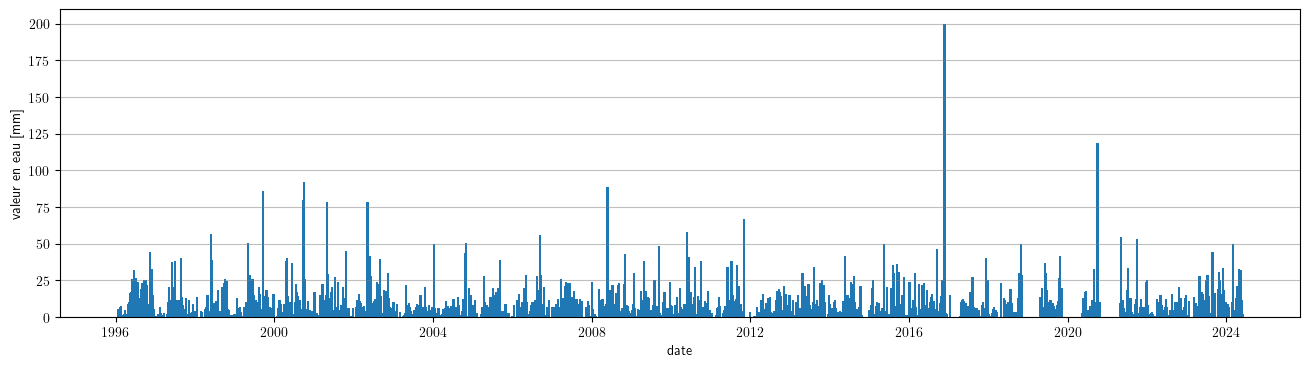

In [124]:
# distribution temporelle des pluies
fig, axs = plt.subplots(figsize=(16, 4))
axs.bar(dates,pluie,width=20)
axs.set_xlabel("date")
axs.set_ylabel("valeur en eau [mm]")
fig.savefig("Evolution_Precipitation_poste_"+poste_choisi+".pdf",bbox_inches='tight')
pluie_max = np.nanmax(pluie)
date_max = dates[pluie == pluie_max].to_string(index=False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
axs.grid(axis='y', color='grey',alpha = 0.5)
print(f"La précipitation maximale a été observée le {date_max} et valait {pluie_max:.1f} mm." )

fig.savefig("Evolution_annuelle_precipitations_poste_"+poste_choisi+".pdf",bbox_inches='tight')

### Analyse des valeurs extrêmes

In [51]:
# Analyse des valeurs extrêmes
série_pluie = pd.Series(np.array(pluie),index=np.array(dates)).squeeze()
model = EVA(série_pluie)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model

/home/ancey/anaconda3/lib/python3.9/site-packages/pyextremes/eva.py:131: RuntimeWarning:

32 Null values found in `data` - removing invalid entries



                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              26,873
Start:                       January 1950      End:                             May 2024
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 75      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                              26,873
Start:                       January 1950      End:                             May 2024
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 75      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

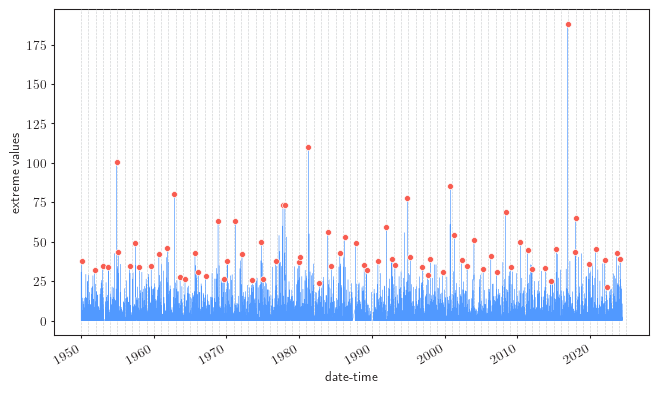

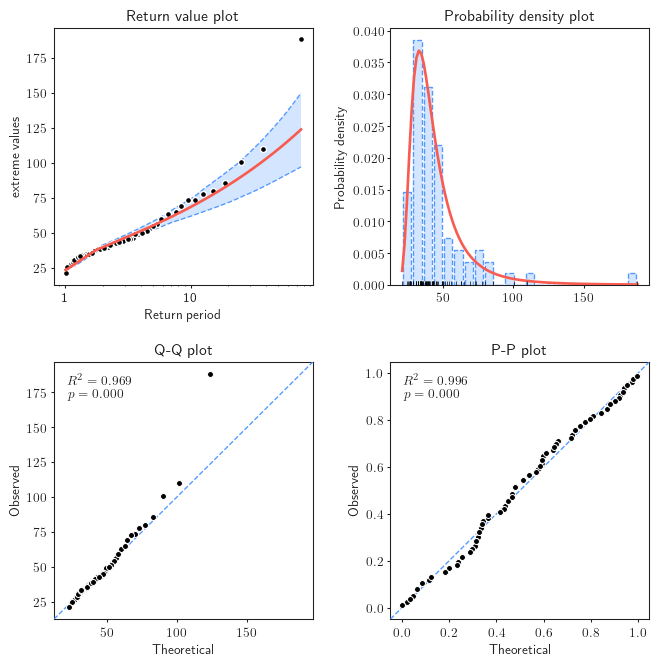

In [52]:
model.plot_extremes()

model.fit_model()
model.plot_diagnostic(alpha=0.7)
model

Text(0, 0.5, '$P$ [mm]')

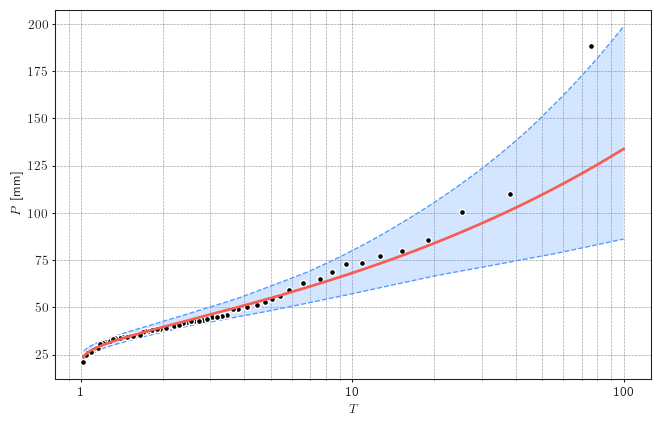

In [117]:

fig, axes = model.plot_return_values(
    return_period=np.logspace(0.01, 2, 200),
    return_period_size="365.2425D",
    alpha=0.95,
)
axes.set_xlabel(r"$T$")
axes.set_ylabel(r"$P$ [mm]")


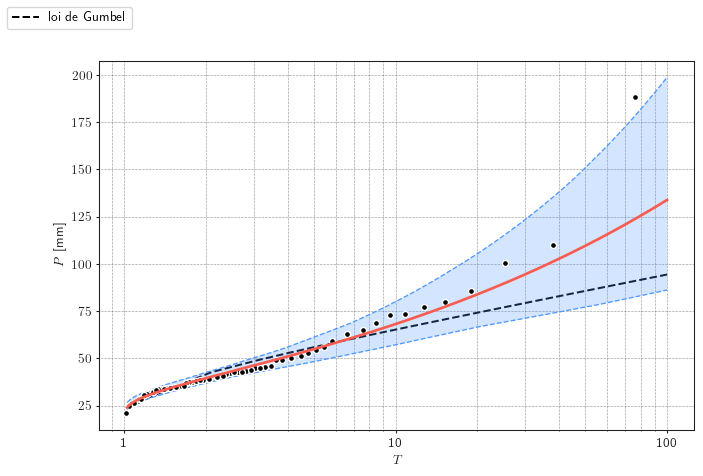

In [118]:
from scipy.stats import gumbel_r, genextreme 
calage_gumbel = gumbel_r.fit(model.extremes.array)
calage_gev    = genextreme.fit(model.extremes.array)

# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
période = np.linspace(1.1,100,100)
quantile = mu-sigma/xi*(1-(-np.log(1-1/période))**(-xi))
#axes.plot(période,quantile,'r','-',label = "loi de Fréchet")
# loi Gumbel
(mu, sigma) = calage_gumbel
période = np.linspace(1.1,100,100)
quantile = mu-sigma *np.log(-np.log(1-1/période) )
  
axes.plot(période,quantile,'--',color='black' , label = "loi de Gumbel")
fig.legend(loc="upper left")
fig

In [105]:
#Estimation des quantiles
summary = model.get_summary(
    return_period=[10, 30, 100],
    alpha=0.95,
    n_samples=1000,
)
summary


,return value,lower ci,upper ci
return period,,,
10.0,68.257961,57.369505,82.543853
30.0,94.529803,71.417908,129.649674
100.0,133.904499,89.002925,217.414129


### Analyse des températures

In [ ]:
température_annuelle  = np.array(série.groupby(by = [série['date'].dt.year])['Tmoy'].mean())
dates_température     = série.groupby(by = [série['date'].dt.year])['date'].first()
dates_température_an  = np.array(dates_température.dt.year)
slope, intercept, r_value, p_value, std_err = stats.linregress(dates_température_an, température_annuelle)
trendline = intercept + slope*dates_température_an

fig, axs = plt.subplots(figsize=(16, 4))
axs.plot(dates,Tmin,color = "skyblue", alpha = 0.5, label = "température minimale")
axs.plot(dates,Tmax,color = "red", alpha = 0.5, label = "température maximale")
axs.plot(dates_température,trendline,color = "black", alpha = 0.95, label = "tendance linéaire")
axs.set_ylabel("Température [°C]")
axs.grid(axis='y', color='grey', alpha = 0.7)
fig.legend(loc = "outside upper left")
print("On observe un accroissement de température de {:.1f} °C par siècle.".format(100*slope))

fig.savefig("Evolution_Tendance_Température_poste_"+poste_choisi+".pdf",bbox_inches='tight')

### Evolution de la température

La température journalière moyenne est T = 3.0 °C.


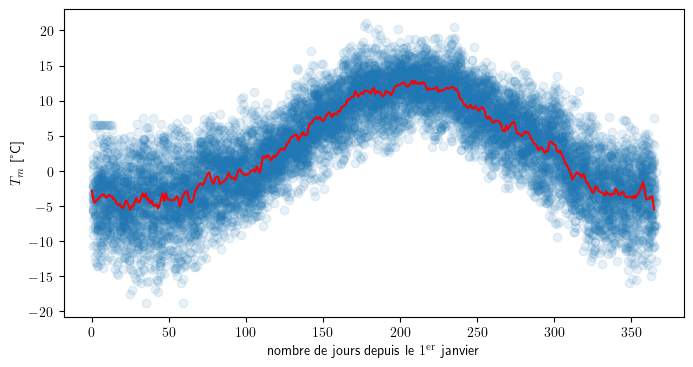

In [121]:
# évolution des températures au cours d'une année
jour_civil = np.array(dates.dt.dayofyear)
valT = 0.5*(np.array(série["Tmin"])+np.array(série["Tmax"]))
moyenne_Température = []
for i in range(1,367):
    moyenne_Température.append(np.nanmean(valT[jour_civil == i] ))  
fig, axs = plt.subplots(figsize=(8, 4))
axs.scatter(jour_civil,valT, alpha = 0.1)
axs.plot(moyenne_Température,color = "red")
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
print("La température journalière moyenne est T = {:0.1f} °C.".format(np.mean(moyenne_Température)))

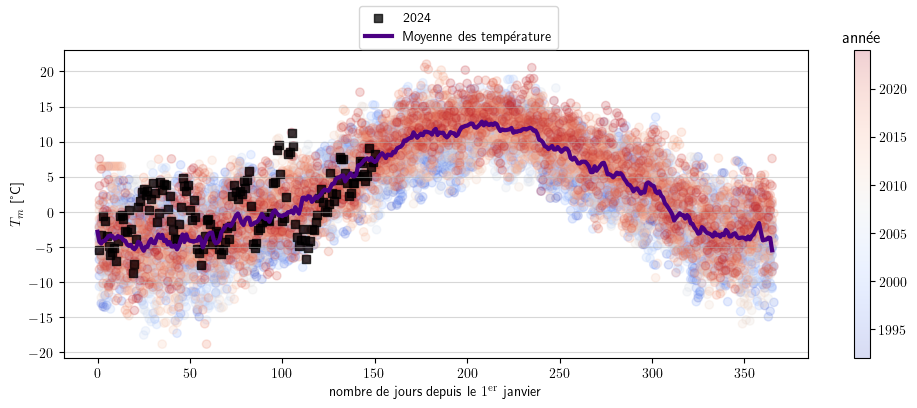

In [126]:
# Evolution moyenne de la température au fil de la saison
jour_civil = np.array(dates.dt.dayofyear)

jour_civil_2024  = np.array(série[série['date'].dt.year == 2024]['date'].dt.dayofyear)
température_2024 = np.array(série[série['date'].dt.year == 2024]['Tmoy'])

valT = np.array(série["Tmoy"])
moyenne_température = []
for i in range(1,367):
    moyenne_température.append(np.nanmean(valT[jour_civil == i] ))  

fig, axs = plt.subplots(figsize=(12, 4))
diag_TM = axs.scatter(jour_civil,valT, alpha = 0.2, c=np.array(série['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_2024,température_2024, alpha = 0.75, marker = "s", color = "black", label = "2024" )
axs.plot(moyenne_température,color = "indigo", linewidth=3.0, label = "Moyenne des température")
cbar = fig.colorbar(diag_TM)
cbar.ax.set_title('année', rotation=0)
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
fig.legend(loc='outside upper center')
axs.grid(axis="y",alpha=0.5)
fig.savefig("Evolution_annuelle_Température_poste_"+poste_choisi+".pdf",bbox_inches='tight')

### Données nivologiques 1950-2024

In [127]:
# années 1950-2022
nom_csv_1 = "nivo-1950-2022"
fichier   = os.path.join(répertoire_travail, nom_csv_1) + '.csv'
print(fichier)
télécharger_fichier(lien_3, nom_csv_1)
décompresser_archive(nom_csv_1)
données_totales_3 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_1   = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
chute_1   = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["HNEIGEF"]
hauteur_1 = données_totales_3[données_totales_3["NUM_POSTE"]==int(poste_choisi) ]["NEIGETOTX"]

# années 2023-2024
nom_csv_2 = "nivo-2023-2024"
fichier   = os.path.join(répertoire_travail, nom_csv_2) + '.csv'
print(fichier)
télécharger_fichier(lien_4, nom_csv_2)
décompresser_archive(nom_csv_2)
données_totales_4 = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"])
dates_2   = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["AAAAMMJJ"]
chute_2   = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["HNEIGEF"]
hauteur_2 = données_totales_4[données_totales_4["NUM_POSTE"]==int(poste_choisi) ]["NEIGETOTX"]


/home/ancey/Météo-France/meteo.data/base/73/nivo-1950-2022.csv
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.
/home/ancey/Météo-France/meteo.data/base/73/nivo-2023-2024.csv
Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


In [128]:
# agrégation des données
dates    = pd.concat([dates_1,dates_2])
chute    = pd.concat([chute_1,chute_2])
hauteur  = pd.concat([hauteur_1,hauteur_2])
série_neige = pd.DataFrame()
série_neige['date']  = dates
série_neige['chute'] = chute
série_neige['hauteur'] = hauteur
# Nettoyage
série_neige.fillna(method='ffill', inplace=True)

if série_neige[~série_neige['chute'].isna()].empty: 
      print("pas de données de chutes de neige")
      existe_chute = False
else:
      if série_neige[~série_neige['chute'].isna()]['chute'].max() == 0: 
            print("Je trouve bien des données, mais elles sont nulles !")
            existe_chute = False
      else:
            print("J'ai trouvé {:.0f} valeurs en tout".format(série_neige[~série_neige['chute'].isna()]['chute'].count()))
            existe_chute = True

if série_neige[~série_neige['hauteur'].isna()].empty: 
      print("pas de données de hauteur de neige")
      existe_hauteur = False
else:
      if série_neige[~série_neige['hauteur'].isna()]['hauteur'].max() == 0: 
            print("Je trouve bien des données, mais elles sont toute nulles !")
            existe_hauteur = False
      else:
            print("J'ai trouvé {:.0f} valeurs en tout".format(série_neige[~série_neige['hauteur'].isna()]['hauteur'].count()))
            existe_hauteur = True


pas de données de chutes de neige
Je trouve bien des données, mais elles sont toute nulles !


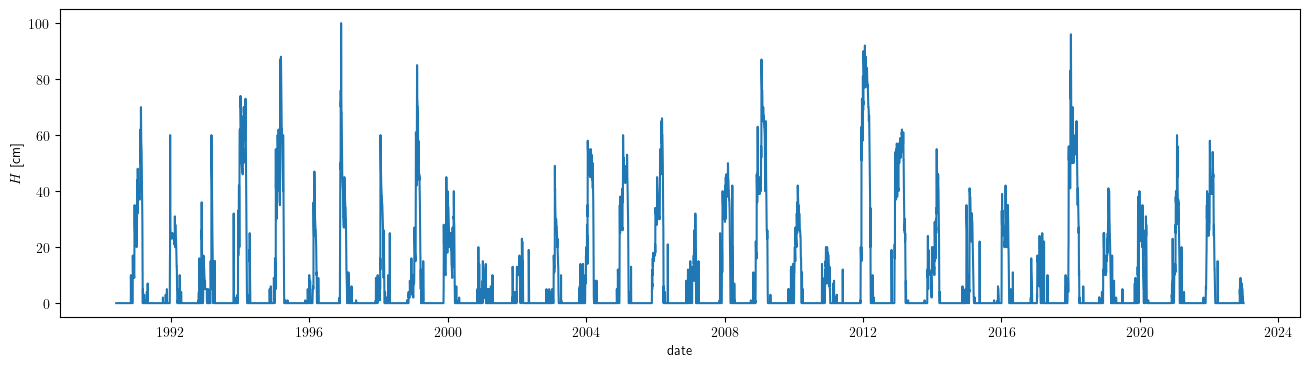

In [19]:
# variation de la hauteur de neige
if existe_hauteur:
      fig, axs = plt.subplots(figsize=(16, 4))
      axs.plot(dates,hauteur)
      axs.set_ylabel(r'$H $  [cm]')
      axs.set_xlabel(r'date')
else:
      print("Pas de données !")

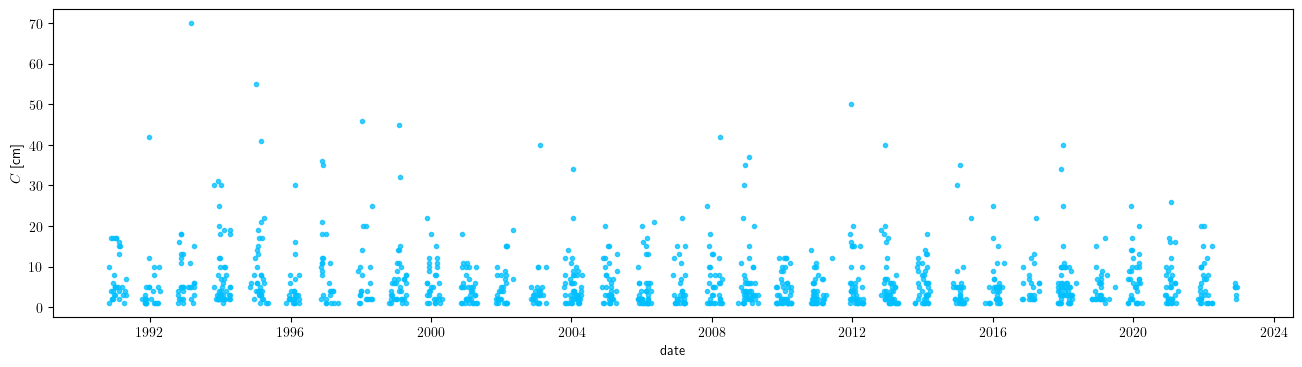

In [20]:
# variation des chutes de neige
if existe_chute:
      fig, axs = plt.subplots(figsize=(16, 4))
      axs.scatter(dates[chute>0],chute[chute>0],   marker = "." , color='deepskyblue', alpha=0.75)
      axs.set_ylabel(r'$C$  [cm]')
      axs.set_xlabel(r'date')
else:
      print("Pas de données !")

Text(0.5, 0, 'date')

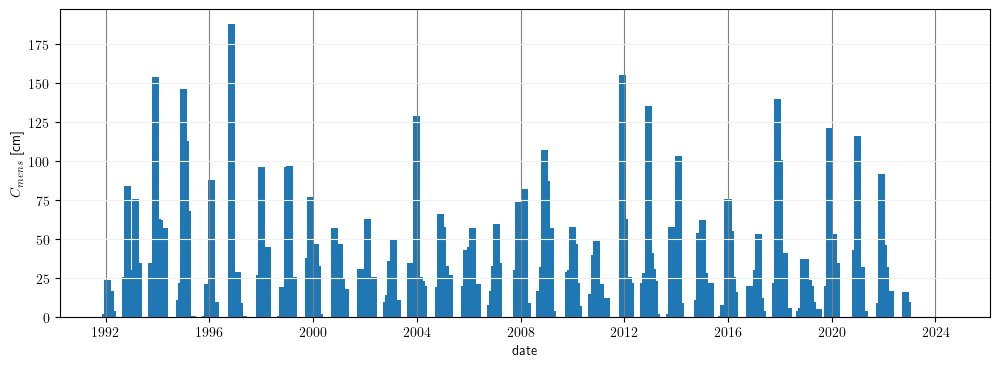

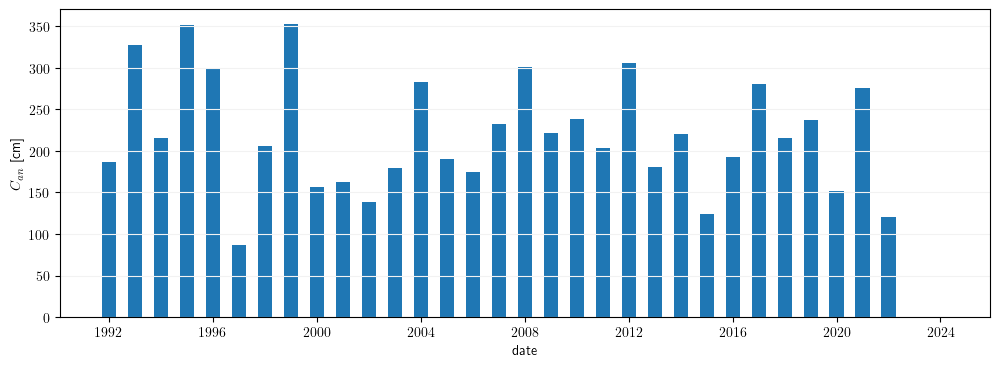

In [21]:


cumul_mensuel = série_neige.groupby(by = [série_neige['date'].dt.month, série_neige['date'].dt.year])['chute'] .sum()
dates_cum     = série_neige.groupby(by = [série_neige['date'].dt.month, série_neige['date'].dt.year])['date'].first()

cumul_annuel  = série_neige.groupby(by = [série_neige['date'].dt.year])['chute'] .sum()
dates_an      = série_neige.groupby(by = [ série_neige['date'].dt.year])['date'].first()

# Ajuste l'année de départ
véritable_année_début = dates_an[(cumul_annuel>0) & (dates_an.dt.month == 1)].first_valid_index()
cumul_mensuel = cumul_mensuel[dates_cum.dt.year>véritable_année_début]
dates_cum     = dates_cum[dates_cum.dt.year>véritable_année_début]

cumul_annuel  = cumul_annuel[dates_an.dt.year>véritable_année_début]
dates_an      = dates_an[dates_an.dt.year>véritable_année_début]

#cumul mensuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_cum,cumul_mensuel,width=100)
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='gray')
axs.set_ylabel(r'$C_{mens}$  [cm]')
axs.set_xlabel(r'date')


#cumul annuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_an,cumul_annuel,width=200)
plt.grid(axis='y', color='0.95')
axs.set_ylabel(r'$C_{an}$  [cm]')
axs.set_xlabel(r'date')


In [30]:
série_neige.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14478 entries, 1076823 to 25695
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     14478 non-null  datetime64[ns]
 1   chute    12417 non-null  float64       
 2   hauteur  12417 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 452.4 KB


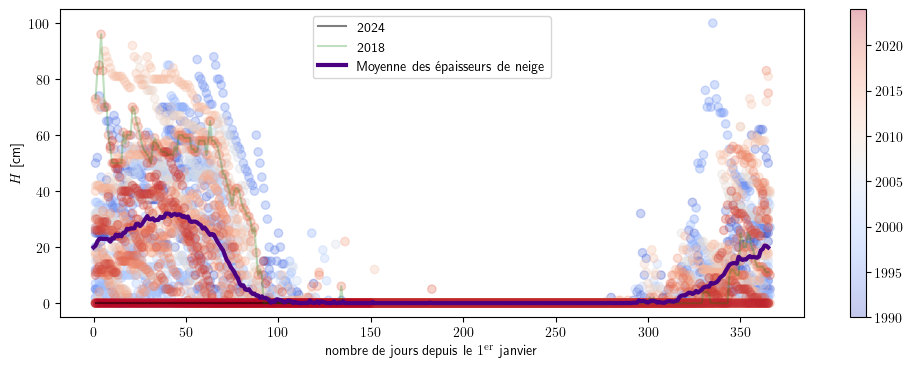

In [22]:
jour_civil = np.array(série_neige['date'].dt.dayofyear)


jour_civil_2018  = np.array(série_neige[série_neige['date'].dt.year == 2018]['date'].dt.dayofyear)
hauteur_2018 = np.array(série_neige[série_neige['date'].dt.year == 2018]['hauteur'])
 

jour_civil_2024  = np.array(série_neige[série_neige['date'].dt.year == 2024]['date'].dt.dayofyear)
hauteur_2024 = np.array(série_neige[série_neige['date'].dt.year == 2024]['hauteur'])


valH = np.array(série_neige["hauteur"])
moyenne_hauteur = []
min_hauteur = []
max_hauteur = []
for i in range(1,367):
    valeurs = valH[jour_civil == i]
    if np.isnan(valeurs).all(): 
        minval = 0 #np.nan
        moyval = 0 #np.nan
        maxval = 0 #np.nan
    else:
        minval = np.nanmin(valeurs)
        maxval = np.nanmax(valeurs)
        moyval = np.nanmean(valeurs)
    min_hauteur.append(minval) 
    max_hauteur.append(maxval)
    moyenne_hauteur.append(moyval)
 

 

fig, axs = plt.subplots(figsize=(12, 4))
diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(série_neige['date'].dt.year),cmap = 'coolwarm')
axs.plot(jour_civil_2024, hauteur_2024, alpha = 0.5,   color = "black", label = "2024" )
axs.plot(jour_civil_2018, hauteur_2018, alpha = 0.25,   color = "green", label = "2018" )
axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
fig.colorbar(diag_hauteur)
axs.set_ylabel(r'$H$ [cm]')

axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')

Text(0.5, 0, 'nombre de jours par rapport au $1^{\\mathrm{er}}$ janvier')

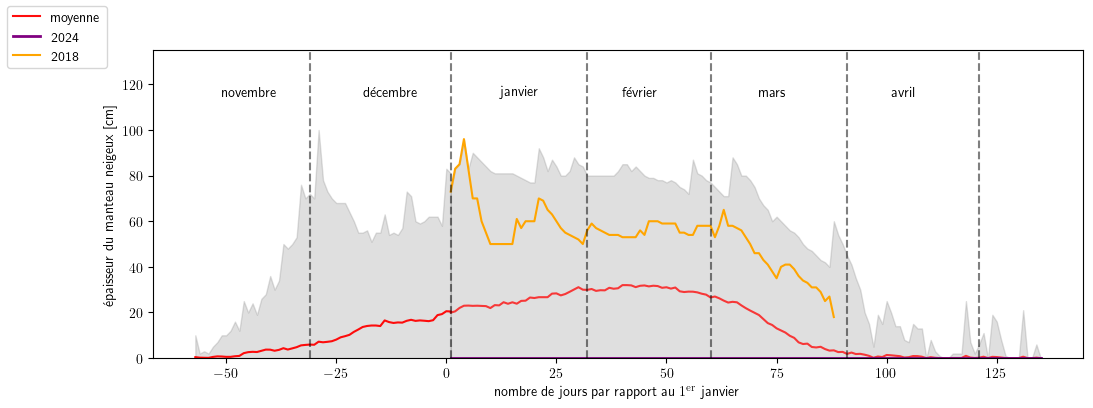

In [25]:
# Evolutio du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "moyenne")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)

axs.plot(jour_civil_2024[0:delta_fin.days],hauteur_2024[0:delta_fin.days] , color ='purple',alpha = 1,linewidth = 2, label = "2024")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "2018")

limite_axe_y = max(axs.get_ylim()) 
axs.set_ylim((0,limite_axe_y+30))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y +10,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')

## Analyse poste quelconque (nivo ou climato)

Cette partie nécessite que chargement_nivo = True et que le fichier a été téléchargéé

In [129]:
poste_choisi = '73144404'
poste_choisi = '73144001'
département = poste_choisi[0:2]
if chargement_nivo:
      if liste_tous_postes[liste_tous_postes['numéro']==poste_choisi].empty:
            print("Erreur : je n'ai pas de données pour ce poste")
      else:
            information_poste = liste_tous_postes[liste_tous_postes['numéro']==poste_choisi]
            print("Le poste a été trouvé dans la liste des postes")
else:
      print("Je n'ai pas téléchargé de fichier de tous les postes. Il faut le faire avec création_liste_postes.ipynb ")
      if selection[selection['num_poste']==poste_choisi ].empty:
            print("Pas de poste dans le fichier des postes actifs. Vérifier les données...")

Le poste a été trouvé dans la liste des postes


In [130]:
information = liste_postes_alpes[liste_postes_alpes['poste']==poste_choisi]
existe_pluie = information['pluie'].to_numpy()[0]
existe_neige = information['neige'].to_numpy()[0]
existe_HN    = information['HN'].to_numpy()[0]
existe_TN    = information['TN'].to_numpy()[0]
existe_TM    = information['TM'].to_numpy()[0]
existe_TX    = information['TX'].to_numpy()[0]
date_début   = information['début'].to_numpy()[0]
date_fin     = information['fin'].to_numpy()[0]
from tabulate import tabulate
print(tabulate([
      ['Numéro  ', poste_choisi], 
      ['Nom  ', information['nom'].to_numpy()[0] ],
      ['Département  ',noms_département[département]],
      ['Altitude  ', str(information['alt'].to_numpy()[0])+' m' ],
      ['Nombre de valeurs  ', information['valeurs'].to_numpy()[0] ],
      ['Date de début  ', datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Date de fin  ', datetime.datetime.strptime(date_fin,"%Y-%m-%d").strftime("%d/%m/%Y")  ],
      ['Cumul de pluie', lecture_bool(existe_pluie)],
      ['Cumul de neige', lecture_bool(existe_neige)],
      ['Hauteur de neige', lecture_bool(existe_HN)],
      ['Température moyenne', lecture_bool(existe_TM)],
      ['Température minimale', lecture_bool(existe_TN)],
      ['Température maximale', lecture_bool(existe_TX)]
      ] ,  tablefmt='orgtbl'))

| Numéro               | 73144001   |
| Nom                  | Mont Cenis |
| Département          | Savoie     |
| Altitude             | 2032 m     |
| Nombre de valeurs    | 22645      |
| Date de début        | 09/01/1992 |
| Date de fin          | 30/05/2024 |
| Cumul de pluie       | oui        |
| Cumul de neige       | non        |
| Hauteur de neige     | oui        |
| Température moyenne  | oui        |
| Température minimale | oui        |
| Température maximale | oui        |


In [28]:
an_début = int(datetime.datetime.strptime(date_début,"%Y-%m-%d").strftime("%Y"))
if 1950<=an_début<=2022: 
      if existe_pluie:
            données_pluie = pd.DataFrame()
            liste_url = [url_M2_département[département], url_M3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_pluie_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_pluie = pd.concat([données_pluie, selection_poste[['AAAAMMJJ','RR','TM','TN','TX']].copy()])
            données_pluie = données_pluie.rename(columns={"AAAAMMJJ": "date", "RR": "pluie"})

if existe_neige:
            données_neige = pd.DataFrame()
            liste_url = [url_N2_département[département], url_N3_département[département] ]
            # boucle pour chaque fichier M 
            for indice_fichier in tqdm(range(2)):
                  archive = 'archives_neige_'+str(indice_fichier)+'_'+département
                  télécharger_fichier( liste_url[indice_fichier], archive, work_verbosity = True) 
                  décompresser_archive(archive, work_verbosity = True)
                  fichier = os.path.join(répertoire_principal, archive) + '.csv'
                  données_totales = pd.read_csv(fichier, sep=";", encoding= 'utf-8',parse_dates=["AAAAMMJJ"],dtype={"NUM_POSTE":str, 'AAAAMMJJ':str})
                  données_totales['NUM_POSTE']= données_totales['NUM_POSTE'].apply(lambda x: x.strip())
                  selection_poste = données_totales[données_totales['NUM_POSTE']==poste_choisi]
                  données_neige = pd.concat([données_neige, selection_poste[['AAAAMMJJ','HNEIGEF','NEIGETOTX']].copy()])
            données_neige = données_neige.rename(columns={"AAAAMMJJ": "date", "HNEIGEF": "neige", "NEIGETOTX": "HN"})

if existe_TX and existe_TN and not existe_TM: données_pluie['TM']=(données_pluie['TN']+données_pluie['TX'])/2
            


  0%|          | 0/2 [00:00<?, ?it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


  0%|          | 0/2 [00:00<?, ?it/s]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

Rien à faire. Le fichier est déjà présent.
Rien à faire. Le fichier est déjà présent.


### Distribution des pluies

In [29]:
# Nettoyage des données en enlevant les valeurs NaN
données_pluie = données_pluie[données_pluie['date']>=date_début]
données_pluie.info()
#données_pluie.set_index('date', inplace=True)
données_pluie.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3538 entries, 772299 to 12785
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3538 non-null   datetime64[ns]
 1   pluie   3442 non-null   float64       
 2   TM      3283 non-null   float64       
 3   TN      3389 non-null   float64       
 4   TX      3390 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 165.8 KB


Le maximum a été atteinte le 09/03/2024 avec un cumul journalier de 157.0 mm.


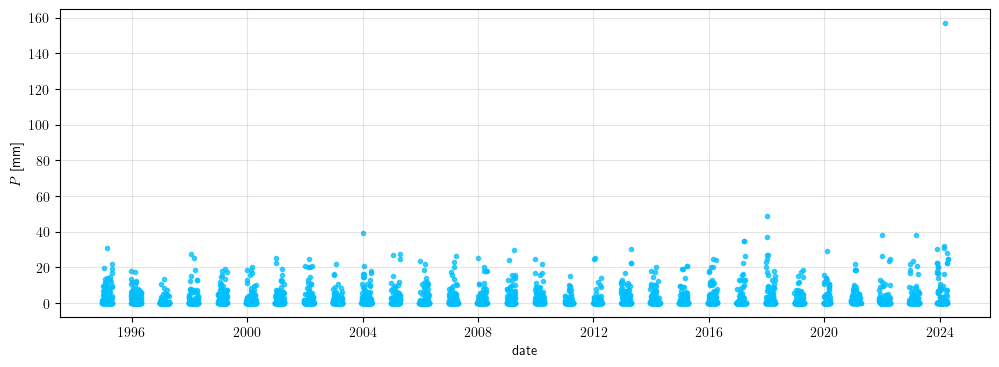

In [31]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_pluie['date'], données_pluie["pluie"] ,marker = "." ,color='deepskyblue', alpha = 0.75)
ax.set_ylabel(r'$P$ [mm]')
ax.set_xlabel(r'date')
date_max = données_pluie[données_pluie['pluie']==max(données_pluie['pluie'])]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
print("Le maximum a été atteinte le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max(données_pluie["pluie"]))  )
plt.grid(True, color = 'gray', alpha=0.2)

fig.savefig("Cumul_pluie_"+poste_choisi+".pdf",bbox_inches='tight')

### Distribution des températures

Le maximum a été atteint le 07/04/2011 avec une température de 16.0 °C.
Le minimum a été atteint le 07/04/2011 avec une température de -16.0 °C.


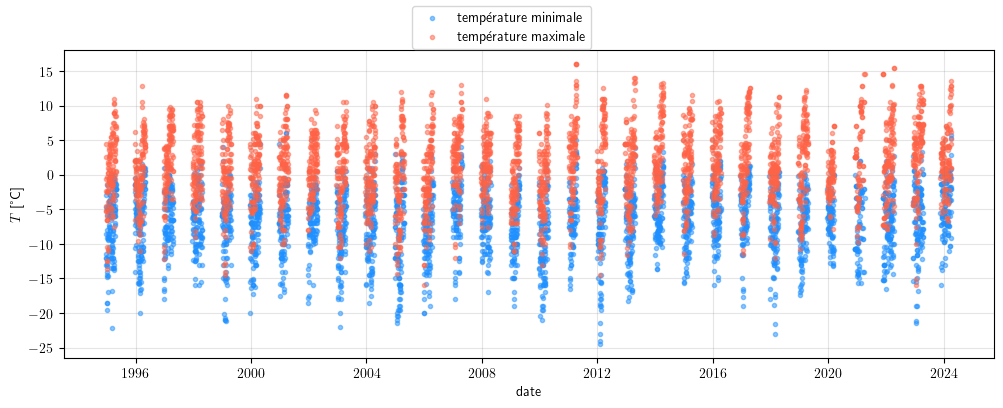

In [32]:
# distribution temporelle des température
fig, ax = plt.subplots(figsize=(12,4))

ax.set_ylabel(r'$T$ [°C]')
ax.set_xlabel(r'date')
# comme il peut y avoir plusieurs multiples on choisit la première occurrence
date_max = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==max(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_min = données_pluie[données_pluie.index  == données_pluie[données_pluie['TX']==min(données_pluie['TX'])].first_valid_index()]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
date_min = datetime.datetime.strptime(date_min ,"%Y-%m-%d").strftime("%d/%m/%Y")
print("Le maximum a été atteint le "+date_max+" avec une température de {:.1f} °C.".format(max(données_pluie["TX"]))  )
print("Le minimum a été atteint le "+date_max+" avec une température de {:.1f} °C.".format(min(données_pluie["TX"]))  )
ax.scatter(données_pluie['date'], données_pluie["TN"] ,marker = "." ,color='dodgerblue', alpha = 0.5,label = "température minimale")
ax.scatter(données_pluie['date'], données_pluie["TX"] ,marker = "." ,color='tomato', alpha = 0.5,label = "température maximale")
fig.legend(loc='outside upper center')
plt.grid(True, color = 'gray', alpha=0.2)

/tmp/ipykernel_9315/4001426243.py:11: RuntimeWarning:

Mean of empty slice



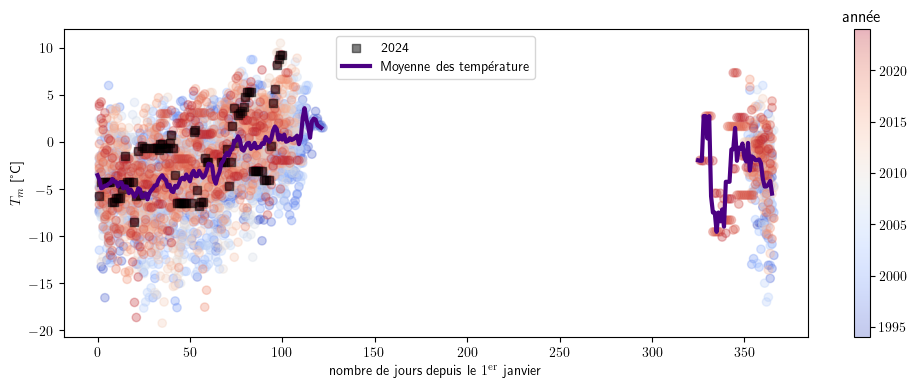

In [34]:
# Evolution moyenne de la température au fil de la saison
jour_civil = np.array(données_pluie['date'].dt.dayofyear)

jour_civil_2024  = np.array(données_pluie[données_pluie['date'].dt.year == 2024]['date'].dt.dayofyear)
température_2024 = np.array(données_pluie[données_pluie['date'].dt.year == 2024]['TM'])


valT = np.array(données_pluie["TM"])
moyenne_température = []
for i in range(1,367):
    moyenne_température.append(np.nanmean(valT[jour_civil == i] ))  

fig, axs = plt.subplots(figsize=(12, 4))
diag_TM = axs.scatter(jour_civil,valT, alpha = 0.3, c=np.array(données_pluie['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_2024,température_2024, alpha = 0.5, marker = "s", color = "black", label = "2024" )
axs.plot(moyenne_température,color = "indigo", linewidth=3.0, label = "Moyenne des température")
cbar = fig.colorbar(diag_TM)
cbar.ax.set_title('année', rotation=0)
axs.set_ylabel(r'$T_m$ [°C]')
axs.set_xlabel(r'nombre')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')


fig.savefig("Evolution_annuelle_Température_poste_"+poste_choisi+".pdf",bbox_inches='tight')


### Neige

In [35]:
# Nettoyage du fichier en enlevant les valeurs NaN
données_neige = données_neige[données_neige['date']>=date_début]
données_neige.info()
#données_neige.set_index('date', inplace=True)
données_neige.fillna(method='ffill', inplace=True)
données_neige.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3556 entries, 545098 to 11925
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3556 non-null   datetime64[ns]
 1   neige   3489 non-null   float64       
 2   HN      3494 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3556 entries, 545098 to 11925
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3556 non-null   datetime64[ns]
 1   neige   3556 non-null   float64       
 2   HN      3556 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 111.1 KB


Le maximum a été atteinte le 07/01/2018 avec un cumul journalier de 61.0 cm.


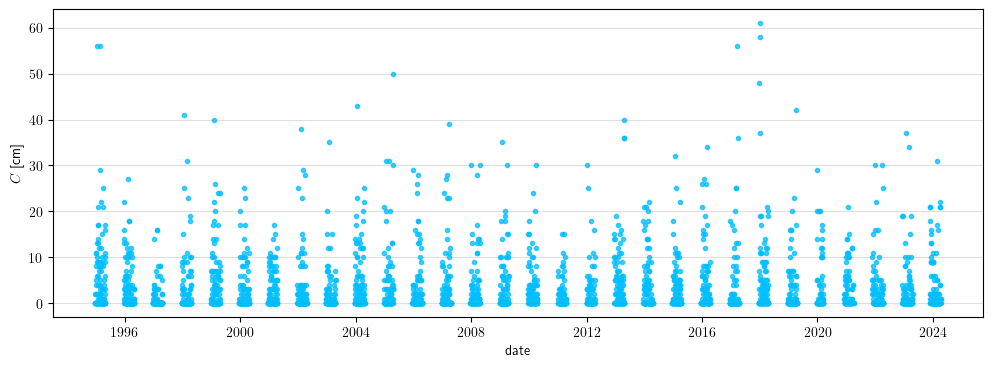

In [36]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_neige['date'], données_neige["neige"] ,marker = "." ,color='deepskyblue', alpha = 0.75)
ax.set_ylabel(r'$C$ [cm]')
ax.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)
date_max = données_neige[données_neige['neige']==max(données_neige['neige'])]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
print("Le maximum a été atteinte le "+date_max+" avec un cumul journalier de {:.1f} cm.".format(max(données_neige["neige"]))  )

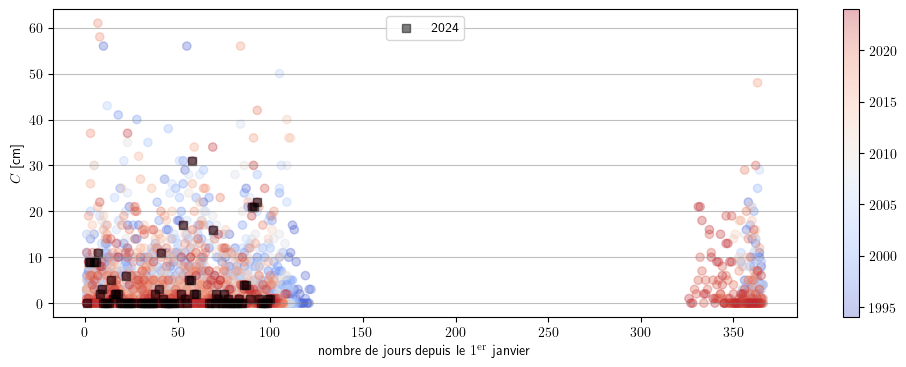

In [37]:
jour_civil = np.array(données_neige['date'].dt.dayofyear)

jour_civil_2024  = np.array(données_neige[données_neige['date'].dt.year == 2024]['date'].dt.dayofyear)
chute_2024 = np.array(données_neige[données_neige['date'].dt.year == 2024]['neige'])
valN = np.array(données_neige["neige"])
 
fig, axs = plt.subplots(figsize=(12, 4))
diag_TN = axs.scatter(jour_civil,valN, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_2024,chute_2024, alpha = 0.5, marker = "s", color = "black", label = "2024" )
plt.grid(axis="y", color = 'gray', alpha = 0.5)
fig.colorbar(diag_TN)
axs.set_ylabel(r'$C$ [cm]')
axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')


Le maximum a été atteinte le 09/01/2018 avec une hauteur de 245 cm.


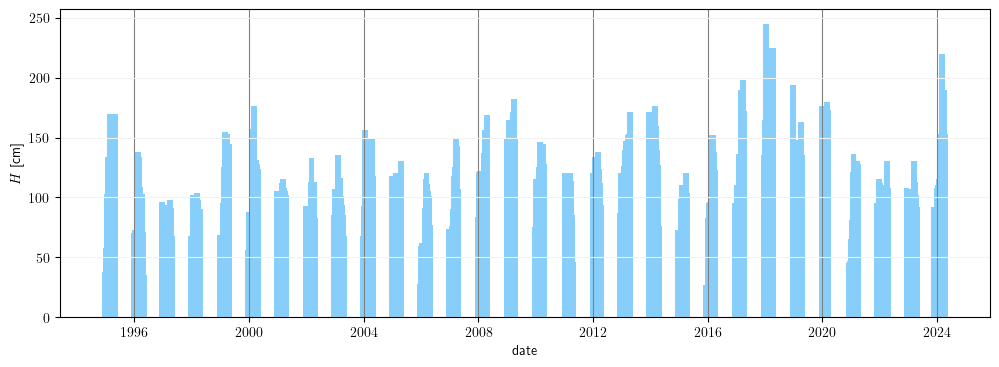

In [39]:
# distribution temporelle des hauteurs du manteux neigeux
date_max = données_neige[données_neige['HN']==max(données_neige['HN'])]['date'].to_string(index = False)
date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")


fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(données_neige['date'],données_neige["HN"],width=75,color = 'lightskyblue')
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='gray')
axs.set_ylabel(r'$H$  [cm]')
axs.set_xlabel(r'date')
print("Le maximum a été atteinte le "+date_max+" avec une hauteur de {:.0f} cm.".format(max(données_neige["HN"]))  )

fig.savefig("Evolution_annuelle_épaisseur_poste_"+poste_choisi+".pdf",bbox_inches='tight')

/tmp/ipykernel_5114/1745391790.py:15: RuntimeWarning:

Mean of empty slice



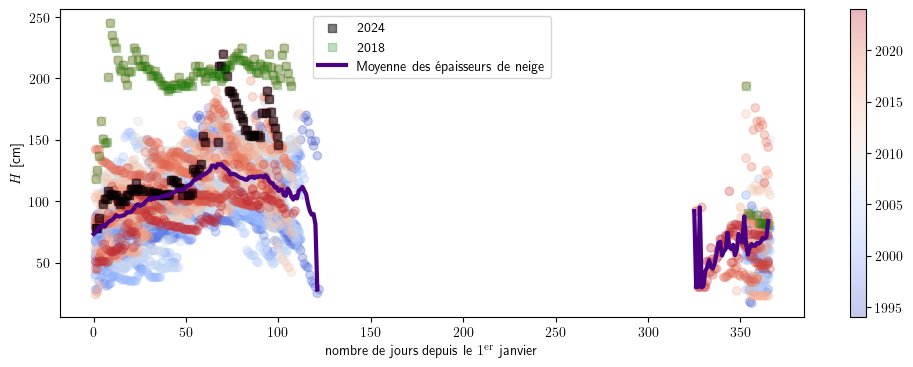

In [502]:
jour_civil = np.array(données_neige['date'].dt.dayofyear)


jour_civil_2018  = np.array(données_neige[données_neige['date'].dt.year == 2018]['date'].dt.dayofyear)
hauteur_2018 = np.array(données_neige[données_neige['date'].dt.year == 2018]['HN'])
 

jour_civil_2024  = np.array(données_neige[données_neige['date'].dt.year == 2024]['date'].dt.dayofyear)
hauteur_2024 = np.array(données_neige[données_neige['date'].dt.year == 2024]['HN'])


valH = np.array(données_neige["HN"])
moyenne_hauteur = []
for i in range(1,367):
    moyenne_hauteur.append(np.nanmean(valH[jour_civil == i] ))   

fig, axs = plt.subplots(figsize=(12, 4))
diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
axs.scatter(jour_civil_2024, hauteur_2024, alpha = 0.5, marker = "s", color = "black", label = "2024" )
axs.scatter(jour_civil_2018, hauteur_2018, alpha = 0.25, marker = "s", color = "green", label = "2018" )
axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
fig.colorbar(diag_hauteur)
axs.set_ylabel(r'$H$ [cm]')

axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')

/tmp/ipykernel_9315/737872625.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_9315/737872625.py:22: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



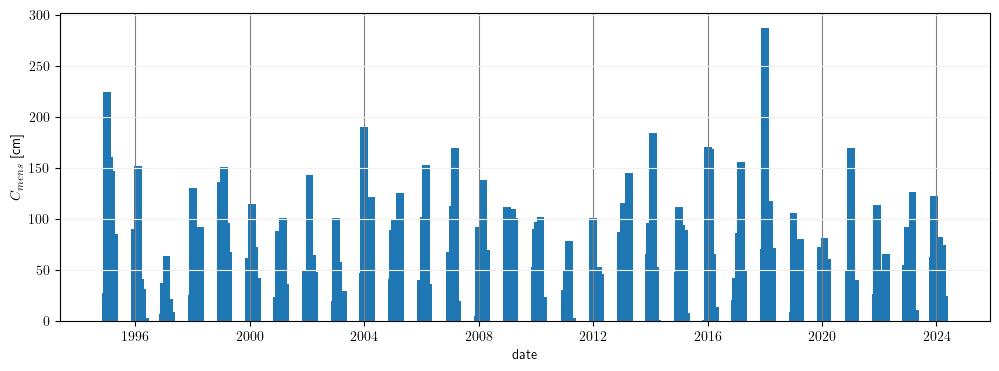

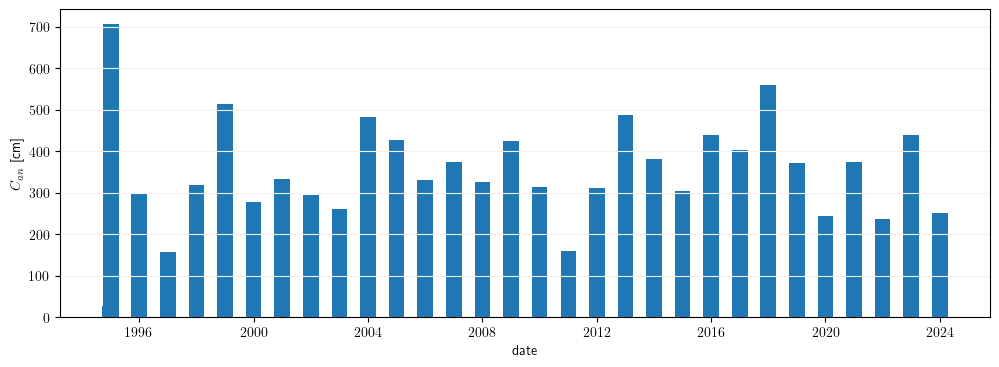

In [40]:
cumul_mensuel = données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['neige'] .sum()
dates_cum=données_neige.groupby(by = [données_neige['date'].dt.month, données_neige['date'].dt.year])['date'].first()

cumul_annuel = données_neige.groupby(by = [données_neige['date'].dt.year])['neige'] .sum()
dates_an=données_neige.groupby(by = [ données_neige['date'].dt.year])['date'].first()

#cumul mensuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_cum,cumul_mensuel,width=100)
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='gray')
axs.set_ylabel(r'$C_{mens}$  [cm]')
axs.set_xlabel(r'date')
fig.show()
fig.savefig("Evolution_cumul_mensuel_poste_"+poste_choisi+".pdf",bbox_inches='tight')

#cumul annuel de neige
fig, axs = plt.subplots(figsize=(12, 4))
axs.bar(dates_an,cumul_annuel,width=200)
plt.grid(axis='y', color='0.95')
axs.set_ylabel(r'$C_{an}$  [cm]')
axs.set_xlabel(r'date')
fig.show()


fig.savefig("Evolution_cumul_annuel_poste_"+poste_choisi+".pdf",bbox_inches='tight')

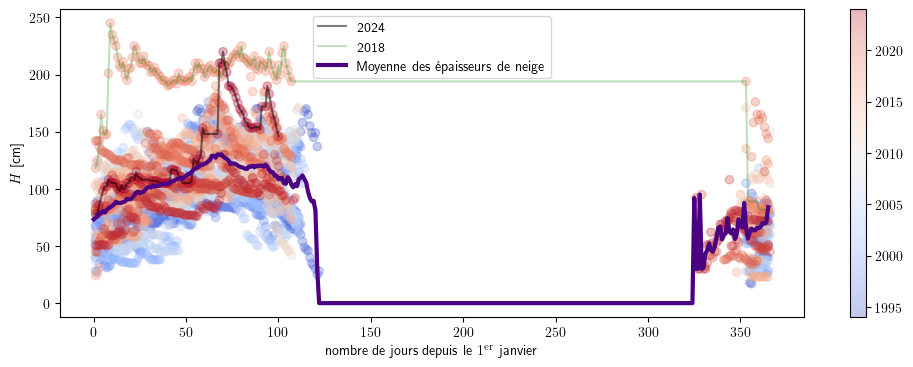

In [41]:
jour_civil = np.array(données_neige['date'].dt.dayofyear)


jour_civil_2018  = np.array(données_neige[données_neige['date'].dt.year == 2018]['date'].dt.dayofyear)
hauteur_2018 = np.array(données_neige[données_neige['date'].dt.year == 2018]['HN'])
 

jour_civil_2024  = np.array(données_neige[données_neige['date'].dt.year == 2024]['date'].dt.dayofyear)
hauteur_2024 = np.array(données_neige[données_neige['date'].dt.year == 2024]['HN'])


valH = np.array(données_neige["HN"])
moyenne_hauteur = []
min_hauteur = []
max_hauteur = []
for i in range(1,367):
    valeurs = valH[jour_civil == i]
    if np.isnan(valeurs).all(): 
        minval = 0 #np.nan
        moyval = 0 #np.nan
        maxval = 0 #np.nan
    else:
        minval = np.nanmin(valeurs)
        maxval = np.nanmax(valeurs)
        moyval = np.nanmean(valeurs)
    min_hauteur.append(minval) 
    max_hauteur.append(maxval)
    moyenne_hauteur.append(moyval)
 

 

fig, axs = plt.subplots(figsize=(12, 4))
diag_hauteur = axs.scatter(jour_civil,valH, alpha = 0.3, c=np.array(données_neige['date'].dt.year),cmap = 'coolwarm')
axs.plot(jour_civil_2024, hauteur_2024, alpha = 0.5,   color = "black", label = "2024" )
axs.plot(jour_civil_2018, hauteur_2018, alpha = 0.25,   color = "green", label = "2018" )
axs.plot(moyenne_hauteur,color = "indigo", linewidth=3.0, label = "Moyenne des épaisseurs de neige")
fig.colorbar(diag_hauteur)
axs.set_ylabel(r'$H$ [cm]')

axs.set_xlabel(r'nombre de jours depuis le $1^{\mathrm{er}}$ janvier')
axs.legend(loc='upper center')

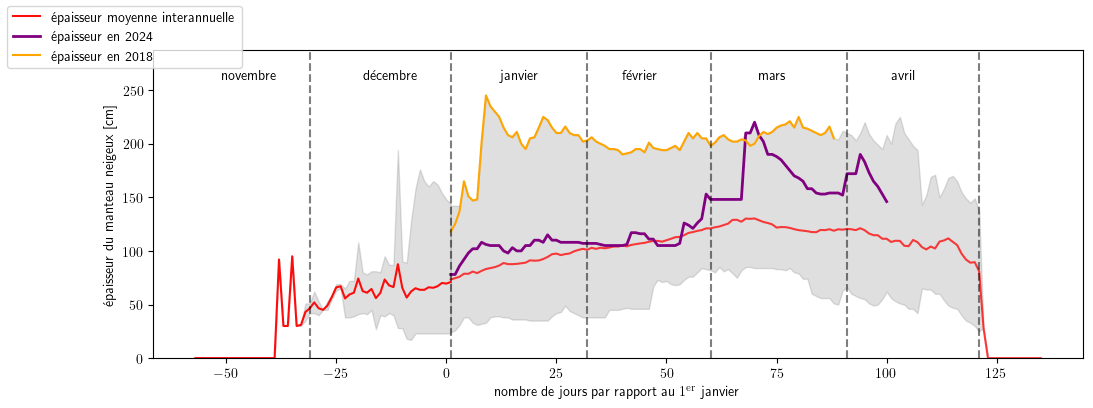

In [48]:
# évolution du manteau neigeux
date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.25)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.25)

axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "épaisseur moyenne interannuelle")
axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] , color ='red',alpha = 0.75)

axs.plot(jour_civil_2024[0:delta_fin.days],hauteur_2024[0:delta_fin.days] , color ='purple',alpha = 1,linewidth = 2, label = "épaisseur en 2024")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "épaisseur en 2018")

limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+30))
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,260,mois_nom[i])
fig.legend(loc='outside upper left')
axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')
plt.savefig("Evolution_manteau_neigeux_"+poste_choisi+"_.pdf",bbox_inches='tight')


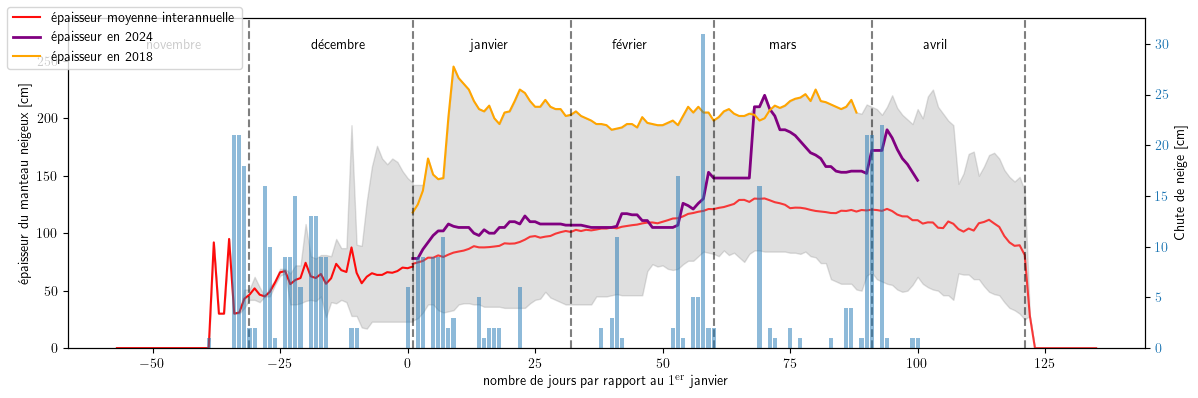

In [49]:
# Détermination des chutes de neige de la saison
saison_2024 = données_neige[(données_neige['date'].dt.year == 2024 )|(( données_neige['date'].dt.year ==2023) & ( données_neige['date'].dt.month >10) )]
chutes_2024 = np.array(saison_2024['neige'])
dates_2024 = saison_2024['date']-datetime.datetime.strptime('31/12/2023', date_format)
dates_2024 = np.array(dates_2024.dt.days)


ax2 = axs.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Chute de neige [cm]' )   
ax2.bar(dates_2024, chutes_2024, color=color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  

fig.savefig("Evolution_manteau_neigeux+chutes_neige_"+poste_choisi+"_.pdf",bbox_inches='tight')
fig

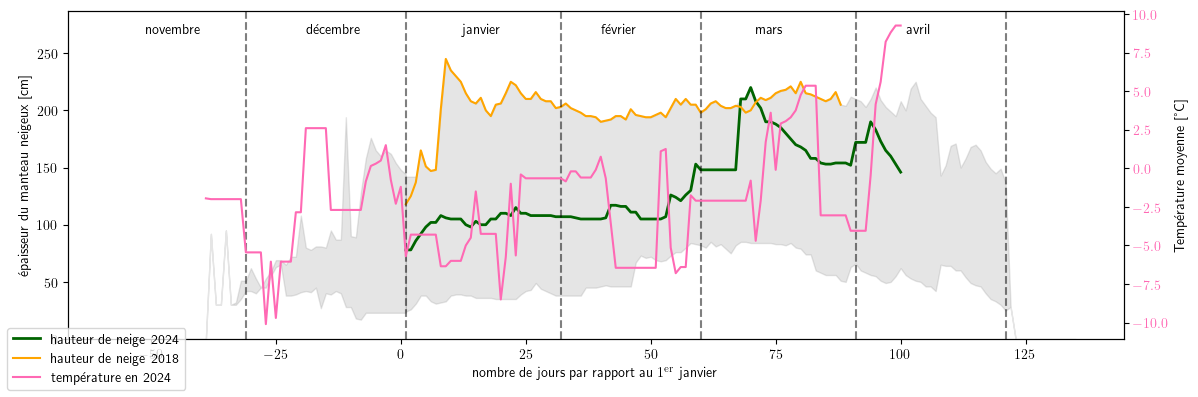

In [50]:
 # Détermination des chutes de neige de la saison
saison_Température_2024 = données_pluie[(données_pluie['date'].dt.year == 2024 )|(( données_pluie['date'].dt.year ==2023) & ( données_pluie['date'].dt.month >10) )]
Température_2024 = np.array(saison_Température_2024['TM'])
saison_Température_2024 = saison_Température_2024['date']-datetime.datetime.strptime('31/12/2023', date_format)
saison_Température_2024 = np.array(saison_Température_2024.dt.days)



date_format = "%d/%m/%Y"

début_saison = datetime.datetime.strptime('01/11/2008', date_format)
fin_année    = datetime.datetime.strptime('31/12/2008', date_format)
fin_saison   = datetime.datetime.strptime('15/05/2008', date_format)
début_année  = datetime.datetime.strptime('01/01/2008', date_format)

delta_fin = fin_saison - début_année
delta_début = fin_année - début_saison
jour_d =np.array(range(366))-363
jour = np.array(range(366))+1
fig, axs = plt.subplots(figsize=(12, 4))

axs.fill_between(jour_d[-delta_début.days:-1],max_hauteur[-delta_début.days:-1],min_hauteur[-delta_début.days:-1] , color ='gray',alpha = 0.2)
axs.fill_between(jour[0:delta_fin.days],max_hauteur[0:delta_fin.days],min_hauteur[0:delta_fin.days] , color ='gray',alpha = 0.2)

#axs.plot(jour_d[-delta_début.days:-1],moyenne_hauteur[-delta_début.days:-1] , color ='red',alpha = 0.95, label = "moyenne")
#axs.plot(jour[0:delta_fin.days],moyenne_hauteur[0:delta_fin.days] ,'--', color ='red',alpha = 0.5)

axs.plot(jour_civil_2024[0:delta_fin.days],hauteur_2024[0:delta_fin.days] , color ='darkgreen',alpha = 1,linewidth = 2, label = "hauteur de neige 2024")

axs.plot(jour_civil_2018[0:(delta_fin.days-47)],hauteur_2018[0:(delta_fin.days-47)] , color ='Orange',alpha = 1, label = "hauteur de neige 2018")

limite_axe_y = max(axs.get_ylim())

axs.set_ylim((0,limite_axe_y+30))


# grille des mois
mois_nom   = ['novembre','décembre','janvier','février','mars','avril']
mois_durée = [-31,1,32,60,91,121]
#ax.axhline(y, linestyle='--', color='k') # horizontal lines
for i in range(6):
      axs.axvline(mois_durée[i], linestyle='--', color='k', alpha = 0.5) # vertical line
      axs.text(mois_durée[i]-20,limite_axe_y + 10,mois_nom[i])

axs.set_ylabel(r"épaisseur du manteau neigeux [cm]")
axs.set_xlabel(r'nombre de jours par rapport au $1^{\mathrm{er}}$ janvier')

ax2 = axs.twinx()   

# tracé des températures
color = 'hotpink'
ax2.set_ylabel('Température moyenne [°C]' )   
ax2.plot(saison_Température_2024, Température_2024, color=color, alpha = 1, linewidth = 1.5, label = "température en 2024")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='outside lower left')
fig.tight_layout()   
fig.savefig("Evolution_température+chutes_neige_"+poste_choisi+"_.pdf",bbox_inches='tight')

91
